In [1]:
from __future__ import print_function, division
from sklearn.datasets import fetch_20newsgroups

In [2]:
from time import time
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from utils import save,load,plot_confusion_matrix

In [3]:
if not os.path.exists('models'):
    os.makedirs('models')

# Part (1) : Building TF-IDF

In [4]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
eight_train = fetch_20newsgroups(subset='all', categories=categories, shuffle=True,
                                  random_state=42, remove=('headers','footers','quotes'))
print("Length of training data ==>", len(eight_train.data))

Length of training data ==> 7882


In [5]:
def initParams(tfidf_min_df):
    stemmer = SnowballStemmer('english')
    analyzer = CountVectorizer().build_analyzer()
    #Use token_pattern parameter with analyzer='word' if no stemming and want to remove words that are only numbers.
    vectorizer = CountVectorizer(stop_words='english', min_df=tfidf_min_df, max_df=0.8, analyzer="word",
                                 strip_accents='ascii', token_pattern='\w*[a-zA-Z]')
    tfidf_transformer = TfidfTransformer()
    return [stemmer, analyzer,vectorizer,tfidf_transformer]

def getTfidf(vectorizer,tfidf_transformer,data,isTraining=True):
    if(isTraining):
        count_data = vectorizer.fit_transform(data)
        tfidf_data = tfidf_transformer.fit_transform(count_data)
    else:
        count_data = vectorizer.transform(data)
        tfidf_data = tfidf_transformer.transform(count_data)        
    return tfidf_data

def stemmedWords(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stemmer, analyzer,vectorizer,tfidf_transformer = initParams(tfidf_min_df=3)

load_from_previous = False

if(load_from_previous):
    training_data = load('models/tfidf_training')
else:
    training_data = getTfidf(vectorizer,tfidf_transformer,eight_train.data)
    save(training_data,'models/tfidf_training')
print('---------------Report Dimensions:---------------')
print('Shape of Training Data ==>', training_data.shape)
print('------------------------------------------------')



---------------Report Dimensions:---------------
Shape of Training Data ==> (7882, 16564)
------------------------------------------------


# PART(2): Applying k-means

In [6]:
def bench_k_means(n_clusters, data, name='k-means++',target_names =['Computer Technology','Recreation']):
    t0 = time()
    estimator = KMeans(n_clusters=n_clusters, init=name, n_init=10, max_iter=500, tol=0.0001, precompute_distances='auto', 
                verbose=0, random_state=42, copy_x=True, n_jobs=1, algorithm='auto')
    estimator.fit(data)
    estimator.homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
    estimator.completeness_score = metrics.completeness_score(labels, estimator.labels_)
    estimator.v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
    estimator.adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
    estimator.adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)
    estimator.contingency_matrix = metrics.cluster.contingency_matrix(labels, estimator.labels_)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             estimator.homogeneity_score,
             estimator.completeness_score,
             estimator.v_measure_score,
             estimator.adjusted_rand_score,
             estimator.adjusted_mutual_info_score,
             ))
    plot_confusion_matrix(estimator.contingency_matrix,target_names,title='Contingency Table',cmap=plt.cm.Spectral)
    return estimator


In [7]:
n_clusters = 2
#kmeans.fit(training_data)
#res = kmeans.predict(testing_data)
#res.shape
labels = list((map(lambda x : 0 if x<4 else 1,eight_train.target)))
labels = np.array(labels)
print(labels.shape)

(7882,)


In [8]:
def execKMeans(data):
    print(92 * '_')
    print('init\t\ttime\tinertia\thomo\tcomp\tv-meas\tARI\tAMI')
    print(92 * '_')
    model = bench_k_means(n_clusters, data, 'k-means++')
    #bench_k_means(n_clusters, data, 'random')
    return model

____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	109.23s	7484	0.426	0.460	0.443	0.444	0.426


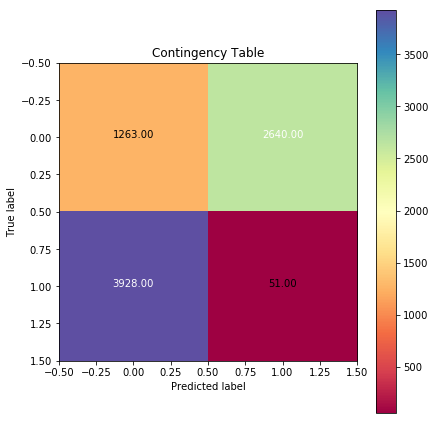

In [12]:
result = execKMeans(training_data)

# PART 3(a): LSI and NMF

In [13]:
def plotMeasures(title, measure):
    plt.title(title)
    plt.xticks( range(9), componentList )
    plt.plot(measure)
    plt.show()

def visualize(modelList):
    homo, comp, vmes, ari, ami = [], [], [], [], []
    for i in range(len(componentList)):
        homo.append(modelList[i].homogeneity_score)
        comp.append(modelList[i].completeness_score)
        vmes.append(modelList[i].v_measure_score)
        ari.append(modelList[i].adjusted_rand_score)
        ami.append(modelList[i].adjusted_mutual_info_score)

    plotMeasures('Homogeneity Score', homo)
    plotMeasures('Completeness Score', comp)
    plotMeasures('V-Measure Score', vmes)
    plotMeasures('Adjusted Random Index', ari)
    plotMeasures('Adjusted Mutual Information', ami)


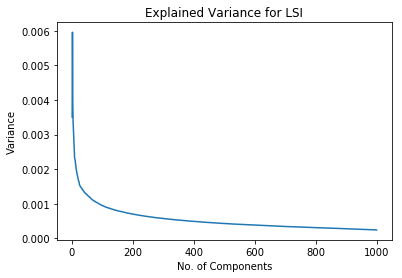

Shape of LSI Training Data ==> (7882, 1000)
Model with 1 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.24s	9	0.018	0.018	0.018	0.025	0.018


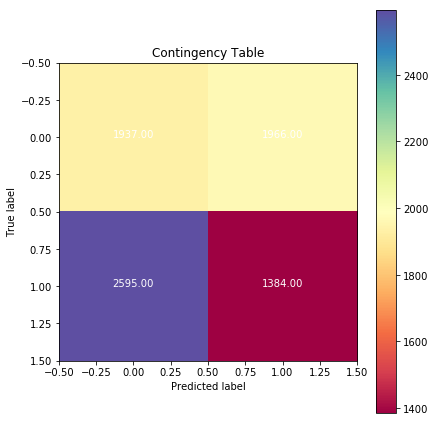

Model with 2 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.40s	41	0.419	0.446	0.432	0.454	0.419


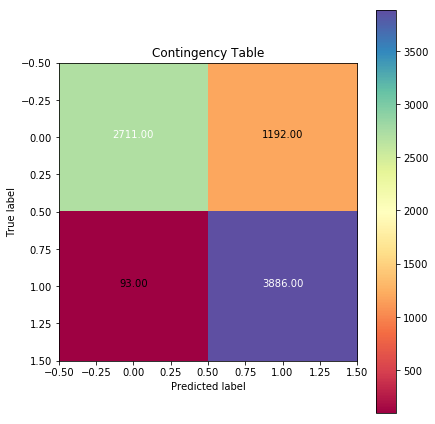

Model with 3 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.23s	71	0.412	0.440	0.425	0.445	0.412


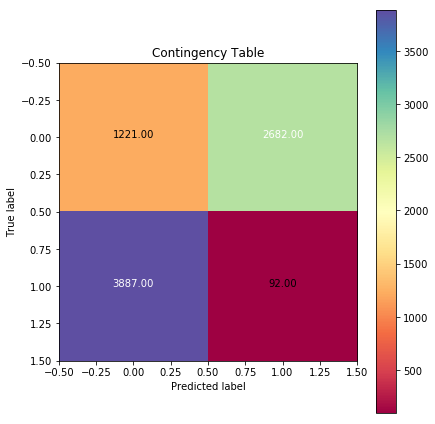

Model with 5 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.24s	119	0.407	0.442	0.424	0.424	0.407


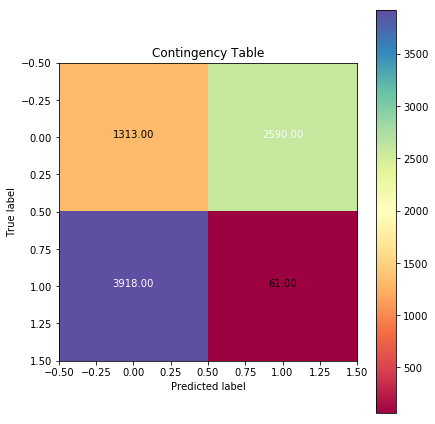

Model with 10 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.56s	216	0.430	0.460	0.444	0.458	0.430


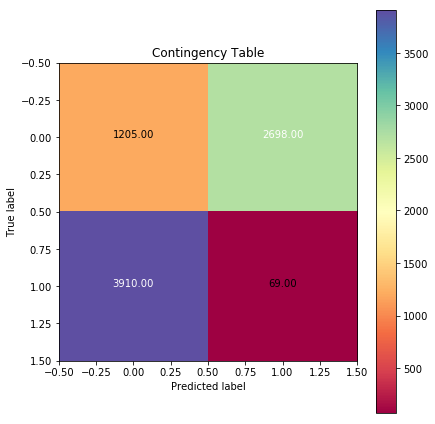

Model with 20 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.74s	363	0.423	0.455	0.439	0.445	0.423


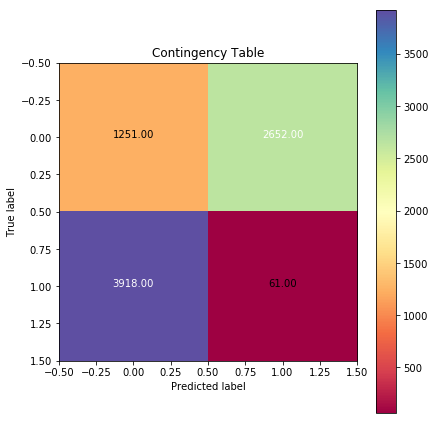

Model with 50 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	1.34s	684	0.420	0.455	0.437	0.436	0.420


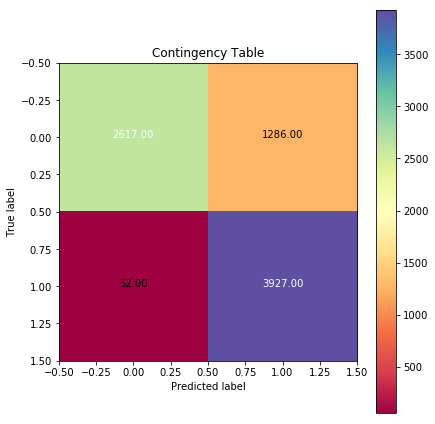

Model with 100 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	1.64s	1090	0.425	0.460	0.442	0.443	0.425


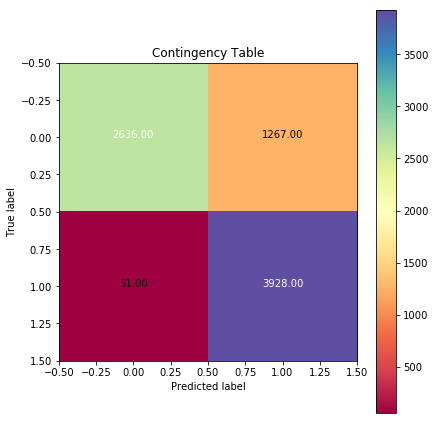

Model with 300 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	5.07s	2172	0.418	0.454	0.436	0.431	0.418


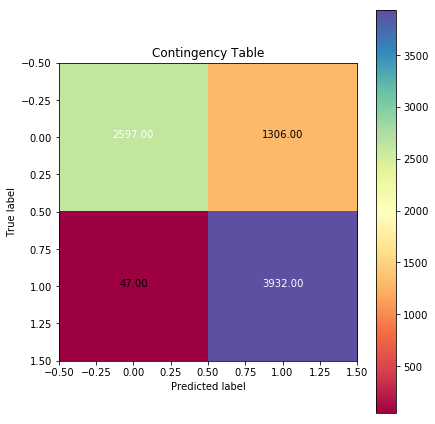

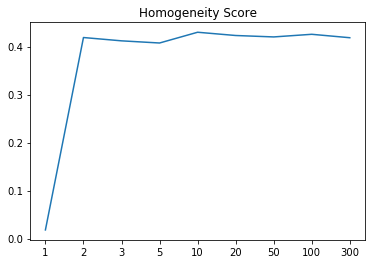

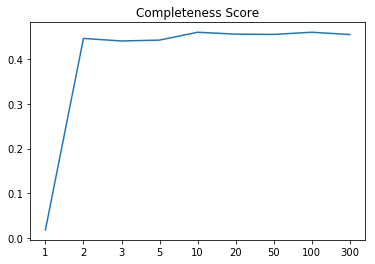

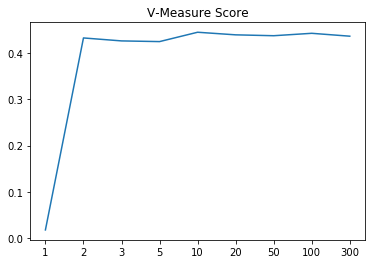

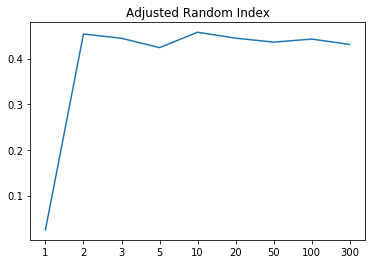

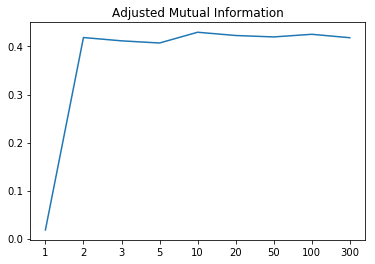

In [14]:
load_from_previous = False
#################### LSI ####################
def getLSI(data,lsi=None,isTrain=True):
    if(isTrain):
        lsi = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
        lsi_data = lsi.fit_transform(data)
    else:
        lsi_data = lsi.transform(data)
    return lsi,lsi_data


#################### LSI #######################
if(load_from_previous):
    model = load('models/lsi_model')
    lsi = model['model']
    lsi_train = model['train']
else:    
    lsi,lsi_train = getLSI(training_data)
    save({'model':lsi,'train':lsi_train},'models/lsi_model')
plt.plot(range(1,1001), lsi.explained_variance_ratio_ )
plt.xlabel('No. of Components')
plt.ylabel('Variance')
plt.title('Explained Variance for LSI')
plt.show()

lsi_models = []
componentList = [1, 2, 3, 5 ,10, 20, 50, 100,300]
print('Shape of LSI Training Data ==>', lsi_train.shape)
for i in componentList:
    print('Model with', i, 'components:')
    lsi_models.append(execKMeans(lsi_train[:,:i]))
save({'lsi_models':lsi_models},'models/kmeans_lsi_models')
visualize(lsi_models)

Model with 1 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.14s	0	0.018	0.018	0.018	0.025	0.018


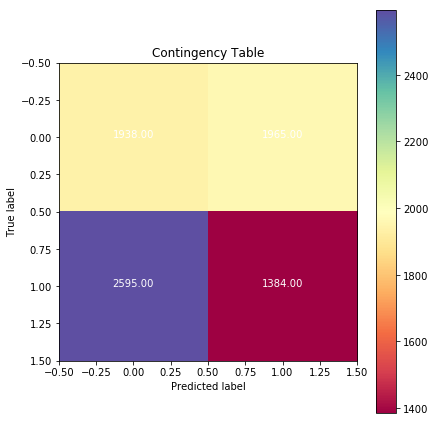

Model with 2 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.22s	1	0.409	0.440	0.424	0.434	0.409


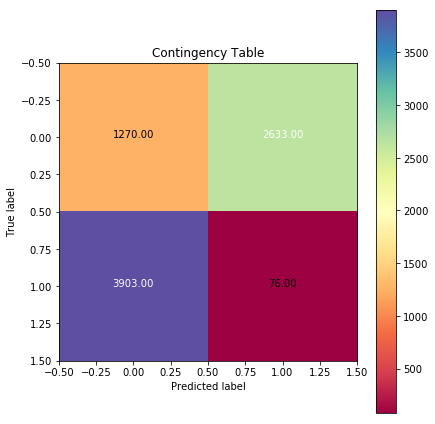

Model with 3 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.15s	3	0.384	0.417	0.400	0.406	0.384


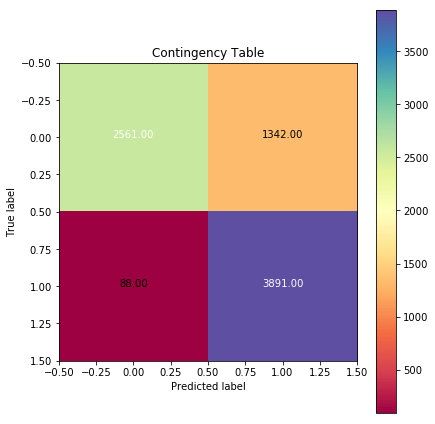

Model with 5 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.17s	8	0.365	0.388	0.376	0.410	0.365


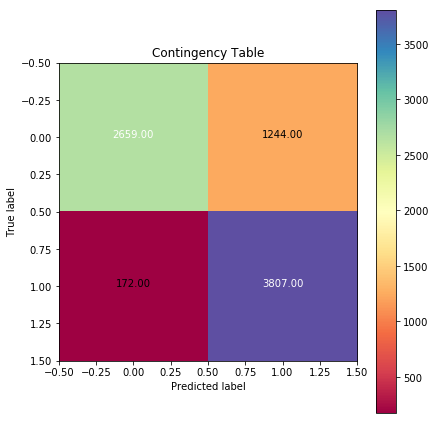

Model with 10 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.48s	18	0.046	0.058	0.051	0.043	0.046


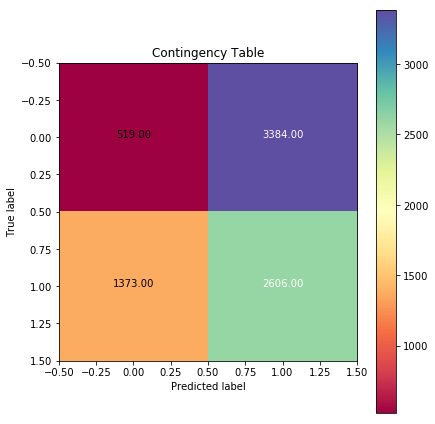

Model with 20 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.70s	35	0.048	0.165	0.074	0.008	0.048


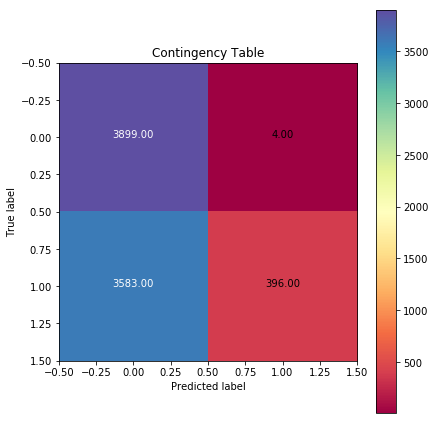

Model with 50 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.81s	81	0.008	0.027	0.012	0.003	0.008


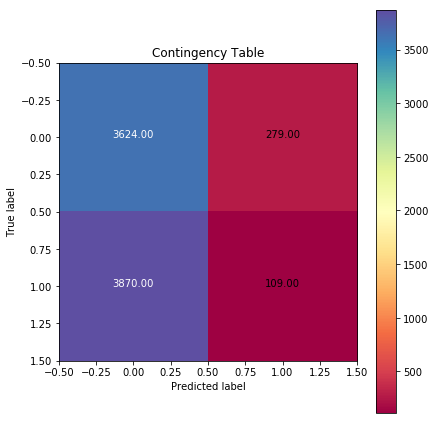

Model with 100 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	1.55s	159	0.000	0.000	0.000	-0.000	-0.000


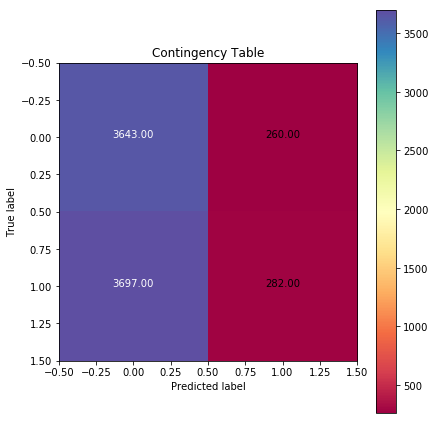

Model with 300 components:
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	2.92s	420	0.010	0.048	0.016	0.002	0.009


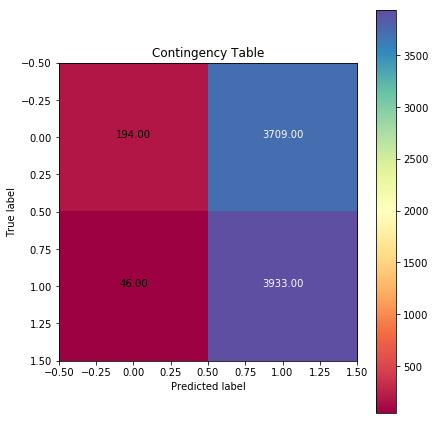

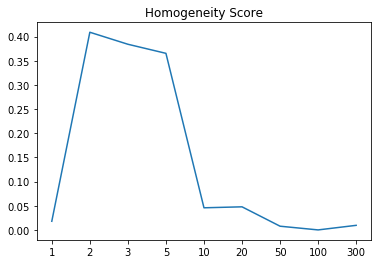

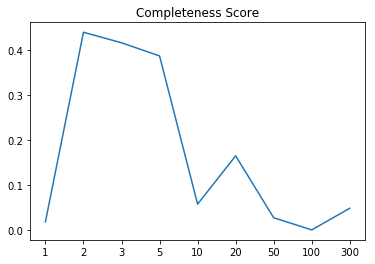

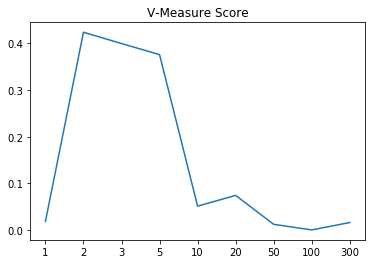

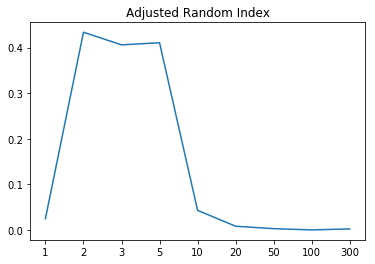

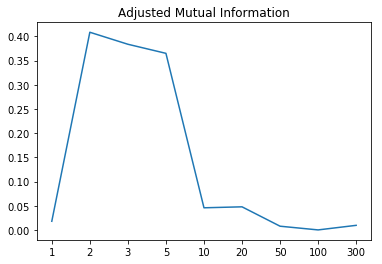

In [11]:
load_from_previous = False

#################### NMF ####################
def getNMF(data,nmf=None,isTrain=True, n_comp=50):
    if(isTrain):
        nmf = NMF(n_components=n_comp, init='random', random_state=42)
        nmf_data = nmf.fit_transform(data)
    else:
        nmf_data = nmf.transform(data)
    return nmf,nmf_data

##################### NMF ####################
nmf_models = []
for i in componentList:
    if(load_from_previous):
        model = load('models/nmf_model_'+str(i))
        nmf = model['model']
        nmf_train = model['train']
    else:    
        nmf,nmf_train = getNMF(training_data, n_comp=i)
        save({'model':nmf,'train':nmf_train},'models/nmf_model_'+str(i))
    print('Model with', i, 'components:')
    nmf_models.append(execKMeans(nmf_train[:,:i]))
save({'nmf_models':nmf_models},'models/kmeans_nmf_models')
visualize(nmf_models)

# 4(a): Visualization

In [29]:
def visualizeClusters(data, title):
    #Visualization
    target_names = ['Computer Technology','Recreation']
    colors = ['blue', 'red']
    for color, i, target_name in zip(colors, [0,1], target_names):
        plt.scatter(data[labels == i, 0], data[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name)
    plt.legend(loc='best', labels=target_names)
    plt.title(title)
    plt.show()
    
def visualizeClusters1(data, title):
    target_names = ['Computer Technology','Recreation']
    colors = ['blue', 'red']
    
    data = scale(data)
    reduced_data = PCA(n_components=2).fit_transform(data)
    
    model = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=500, tol=0.0001, precompute_distances='auto', 
                verbose=0, random_state=42, copy_x=True, n_jobs=1, algorithm='auto')
    model.fit(reduced_data)
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Accent,
               aspect='auto', origin='lower')

    #plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    for color, i, target_name in zip(colors, [0,1], target_names):
        plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], color=color, alpha=.8, lw=2,
                    label=target_name, s=2)
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

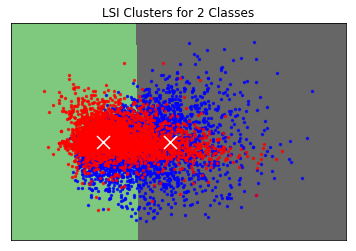

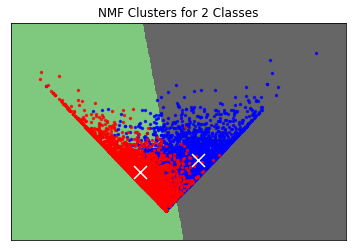

In [30]:
n_comp_lsi = 10
n_comp_nmf = 2

model = load('models/nmf_model_'+str(n_comp_nmf))
nmf = model['model']
nmf_train = model['train']
#visualizeClusters(data=lsi_train, title='LSI Clusters for 2 Classes')
visualizeClusters1(lsi_train[:,:n_comp_lsi], 'LSI Clusters for 2 Classes')
#visualizeClusters(data=nmf_train, title='NMF Clusters for 2 Classes')
visualizeClusters1(nmf_train, 'NMF Clusters for 2 Classes')

# 4(b)(i) : Normalizing

(7882, 10)
Before: [ 0.00334263  0.00568319  0.00373735  0.00322584  0.00301399  0.00284
  0.00266215  0.00237827  0.00221488  0.00218923]
After: [ 0.00012687  0.00012687  0.00012687  0.00012687  0.00012687  0.00012687
  0.00012687  0.00012687  0.00012687  0.00012687]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.56s	9	0.018	0.021	0.019	0.021	0.018


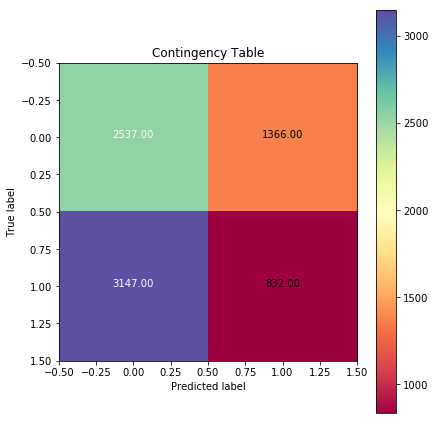

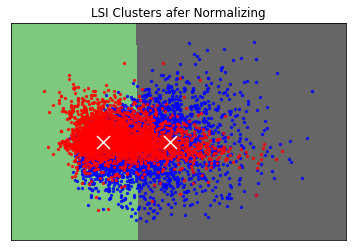

(7882, 2)
Before: [ 0.00011611  0.00027104]
After: [ 0.00012687  0.00012687]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.17s	1	0.450	0.468	0.459	0.510	0.450


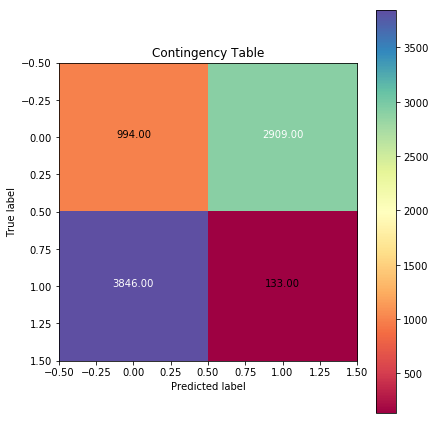

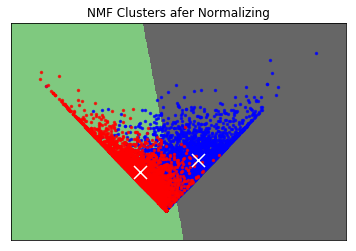

In [32]:
norm_lsi_train = normalize(scale(lsi_train[:,:n_comp_lsi]), axis=0)
print(norm_lsi_train.shape)
print('Before:', np.var(lsi_train[:,:n_comp_lsi], axis=0))
print('After:', np.var(norm_lsi_train, axis=0))
execKMeans(norm_lsi_train[:,:n_comp_lsi])
#visualizeClusters(norm_lsi_train, 'LSI Clusters afer Normalizing')
visualizeClusters1(norm_lsi_train[:,:n_comp_lsi], 'LSI Clusters afer Normalizing')

model = load('models/nmf_model_'+str(n_comp_nmf))
nmf = model['model']
nmf_train = model['train']
norm_nmf_train = normalize(scale(nmf_train), axis=0)
print(norm_nmf_train.shape)
print('Before:', np.var(nmf_train, axis=0))
print('After:', np.var(norm_nmf_train, axis=0))
execKMeans(norm_nmf_train)
#visualizeClusters(norm_nmf_train, 'NMF Clusters after Normalizing')
visualizeClusters1(norm_nmf_train, 'NMF Clusters after Normalizing')

# 4(b)(ii): Logarithmic Transformation

(7882, 2)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.19s	12022	0.467	0.469	0.468	0.567	0.467


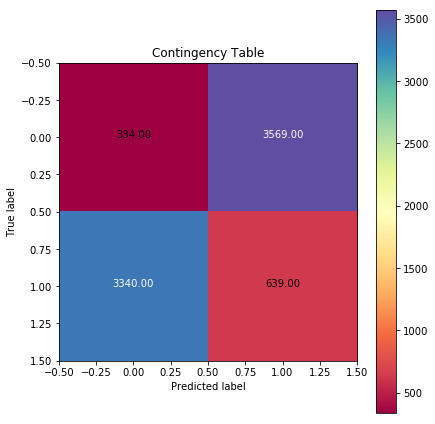

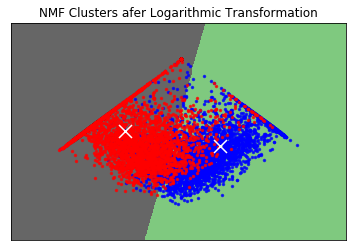

In [37]:
model = load('models/nmf_model_'+str(n_comp_nmf))
nmf = model['model']
nmf_train = model['train']
log_nmf_train = np.log(nmf_train+0.001)
print(log_nmf_train.shape)
execKMeans(log_nmf_train)
#visualizeClusters(log_nmf_train, 'NMF Clusters after Logarithmic Transformation')
visualizeClusters1(log_nmf_train, 'NMF Clusters after Logarithmic Transformation')

# 4(b)(iii): Logarithmic Transformation and Normalization

(7882, 2)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.18s	12022	0.467	0.469	0.468	0.567	0.467


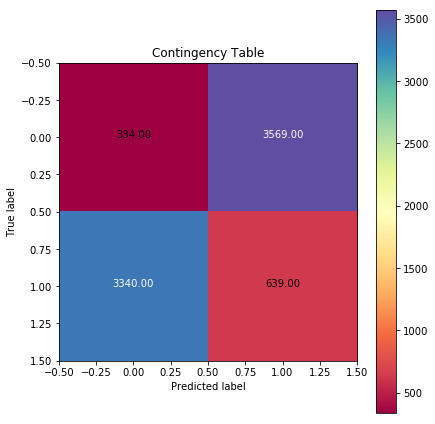

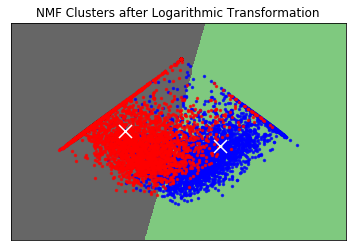

(7882, 2)
Before: [ 1.37383476  2.00619143]
After: [ 0.00012687  0.00012687]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.17s	0	0.489	0.490	0.489	0.597	0.489


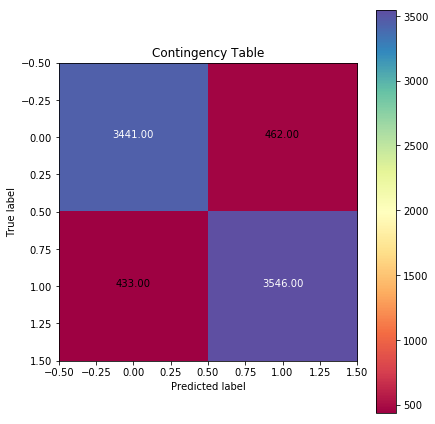

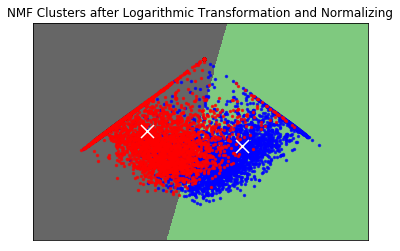

In [35]:
#Take Log and then normalize
model = load('models/nmf_model_'+str(n_comp_nmf))
nmf = model['model']
nmf_train = model['train']
log_nmf_train = np.log(nmf_train+0.001)
print(log_nmf_train.shape)
execKMeans(log_nmf_train)
#visualizeClusters(log_nmf_train, 'NMF Clusters after Logarithmic Transformation')
visualizeClusters1(log_nmf_train, 'NMF Clusters after Logarithmic Transformation')

#Now Normalize
norm_log_nmf_train = normalize(scale(log_nmf_train), axis=0)
print(norm_log_nmf_train.shape)
print('Before:', np.var(log_nmf_train, axis=0))
print('After:', np.var(norm_log_nmf_train, axis=0))
execKMeans(norm_log_nmf_train)
#visualizeClusters(norm_log_nmf_train, 'NMF Clusters after Logarithmic Transformation and Normalizing')
visualizeClusters1(norm_log_nmf_train, 'NMF Clusters after Logarithmic Transformation and Normalizing')



# Normalization and Logarithmic Transformation

(7882, 2)
Before: [ 0.00011611  0.00027104]
After: [  6.00639817e-05   6.89635591e-05]
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.19s	0	0.443	0.464	0.453	0.492	0.443


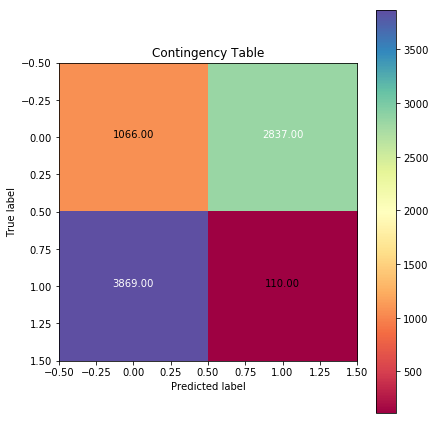

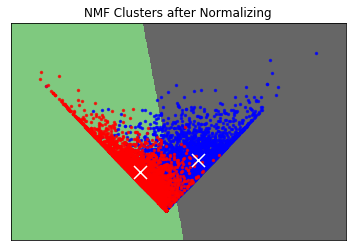

(7882, 2)
____________________________________________________________________________________________
init		time	inertia	homo	comp	v-meas	ARI	AMI
____________________________________________________________________________________________
k-means++	0.15s	9081	0.495	0.495	0.495	0.602	0.495


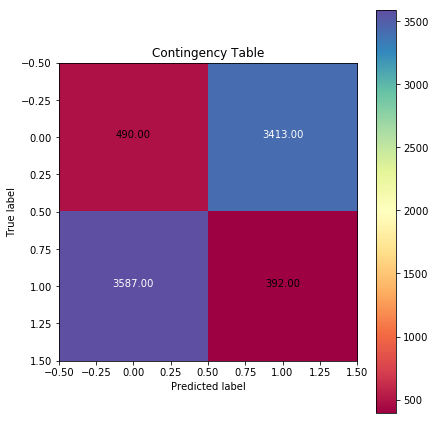

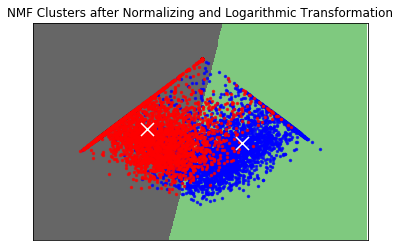

In [36]:
#Normalzie and then take Log
model = load('models/nmf_model_'+str(n_comp_nmf))
nmf = model['model']
nmf_train = model['train']
norm_nmf_train = normalize(nmf_train, axis=0)
print(norm_nmf_train.shape)
print('Before:', np.var(nmf_train, axis=0))
print('After:', np.var(norm_nmf_train, axis=0))
execKMeans(norm_nmf_train)
#visualizeClusters(norm_nmf_train, 'NMF Clusters after Normalizing')
visualizeClusters1(norm_nmf_train, 'NMF Clusters after Normalizing')


#Now take Log
log_norm_nmf_train = np.log(norm_nmf_train+0.001)
print(log_norm_nmf_train.shape)
execKMeans(log_norm_nmf_train)
#visualizeClusters(log_norm_nmf_train, 'NMF Clusters after Normalizing and Logarithmic Transformation')
visualizeClusters1(log_norm_nmf_train, 'NMF Clusters after Normalizing and Logarithmic Transformation')
